In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from data_parsing import load_trajectories
from functools import partial, reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
# from glob import glob
# import os

In [3]:
trajectories, status = load_trajectories('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#trajectories, status = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL', 'data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
#trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')
#id_and_performance = pd.read_csv('data/MITxPRO-AMxB-1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance.iloc[0]
#id_and_performance

In [4]:
# # node list of all students' learning pathway networks
# AM_nodelist = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
# url_id_to_url_hexname = dict(zip(AM_nodelist['order'], AM_nodelist['id']))
# #LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
# #url_id_to_url_hexname = dict(zip(LaaL_nodelist['order'], LaaL_nodelist['name']))
# url_id_to_url_hexname[0] = 'done with course'
# def traj_to_edge_csv(traj, fname):
#     edges = []
#     urls = [url_id_to_url_hexname[url] for url in traj][1:-1]
#     for edge in zip(urls[:-1], urls[1:]):
#             # unpack those two items in the in the pair, and convert them from idex id
#             edges.append(edge)
#     df = pd.DataFrame(data=edges, columns = ['from', 'to'])
#     df.to_csv(fname, index=False)
# #traj_to_edge_csv(trajectories.iloc[0], 'test_traj')

In [5]:
#AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')


Maximum trajectory identified by number of clicks:  3483


Text(0, 0.5, 'Count of students')

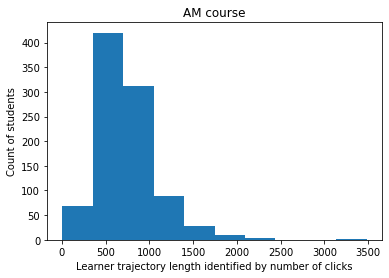

In [6]:
traj_lengths = trajectories.map(len).values
plt.hist(traj_lengths)
print("Maximum trajectory identified by number of clicks: ", max(traj_lengths))
plt.title('AM course')
plt.xlabel('Learner trajectory length identified by number of clicks')
plt.ylabel('Count of students')

## data generators 

In [7]:
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)

incoming_traj = []
outgoing_traj = []

# this split assumes that we don't need to rebalance for unequal category weights
n_valid = int(2*np.sqrt(len(trajectories)))
n_train = len(trajectories) - n_valid
success_rate = status[index[:n_train]].sum() / n_train

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

def data_generator(start, stop, use_status):
     while True:
        for i in range(start, stop):        
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            y = outgoing_traj[index[i]].reshape(1,-1)
            if use_status:
                yield [x,s],y
            else:
                yield x,y

train_generator_simp = partial(data_generator, 0, n_train, False)
valid_generator_simp = partial(data_generator, n_train, n_train+n_valid, False)
train_generator_cond = partial(data_generator, 0, n_train, True)
valid_generator_cond = partial(data_generator, n_train, n_train+n_valid, True)
success_rate

0.7597701149425288

## Define models

In [8]:
hidden_dim = 60
embedding_dim = 30
# turning trajectories into sets of URLs
optimizer = Adam(learning_rate=0.001)
number_of_URL = max(trajectories.sum()) + 1
#number_of_URL = 1121

In [9]:
input_ = Input(shape=(None,), name='history')
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model_simp = Model(inputs=input_, outputs=predicted_URL, name='Simple_model')
model_simp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_simp.summary()

Model: "Simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
history (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          22620     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 60)          21840     
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 754)         45994     
Total params: 90,454
Trainable params: 90,454
Non-trainable params: 0
_________________________________________________________________


In [10]:
input_x = Input(shape=(None,), name='history')
input_s = Input(shape=(None,), name='status')
embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

model_cond = Model(inputs=[input_x, input_s], outputs=predicted_URL, name='Conditional_model')
model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_cond.summary()

Model: "Conditional_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
URL_embedding (Embedding)       (None, None, 30)     22620       history[0][0]                    
__________________________________________________________________________________________________
status (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, None, 60)     21840       URL_embedding[0][0]              
__________________________________________________________________________________

## Run models

In [11]:
#model_simp.load_weights('weights/')
model_cond.load_weights('weights/AM_cond_hiddim60-.hdf5', by_name=True)

In [12]:
filepath="AM_cond_hiddim60-.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model_cond.fit_generator(train_generator_cond(), 
                    validation_data=valid_generator_cond(),
                    callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=150,
                    verbose=1,)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 870 steps, validate for 60 steps
Epoch 1/150
869/870 [============================>.] - ETA: 0s - loss: 1.4242 - acc: 0.6292
Epoch 00001: val_loss improved from inf to 1.75930, saving model to AM_cond_hiddim60-.hdf5
870/870 [==============================] - 304s 350ms/step - loss: 1.4237 - acc: 0.6294 - val_loss: 1.7593 - val_acc: 0.5862
Epoch 2/150
869/870 [============================>.] - ETA: 0s - loss: 1.4215 - acc: 0.6294
Epoch 00002: val_loss improved from 1.75930 to 1.75867, saving model to AM_cond_hiddim60-.hdf5
870/870 [==============================] - 285s 328ms/step - loss: 1.4210 - acc: 0.6296 - val_loss: 1.7587 - val_acc: 0.5865
Epoch 3/150
869/870 [============================>.] - ETA: 0s - loss: 1.4202 - acc: 0.6297
Epoch 00003: val_loss did not improve from 1.75867
870/870 [==============================] - 285s 327ms/step - loss: 1

Epoch 30/150
869/870 [============================>.] - ETA: 0s - loss: 1.3953 - acc: 0.6335
Epoch 00030: val_loss did not improve from 1.75867
870/870 [==============================] - 282s 324ms/step - loss: 1.3948 - acc: 0.6337 - val_loss: 1.7680 - val_acc: 0.5860
Epoch 31/150
869/870 [============================>.] - ETA: 0s - loss: 1.3955 - acc: 0.6333
Epoch 00031: val_loss did not improve from 1.75867
870/870 [==============================] - 282s 325ms/step - loss: 1.3950 - acc: 0.6335 - val_loss: 1.7689 - val_acc: 0.5861
Epoch 32/150
869/870 [============================>.] - ETA: 0s - loss: 1.3932 - acc: 0.6337
Epoch 00032: val_loss did not improve from 1.75867
870/870 [==============================] - 282s 325ms/step - loss: 1.3927 - acc: 0.6338 - val_loss: 1.7685 - val_acc: 0.5865
Epoch 33/150
869/870 [============================>.] - ETA: 0s - loss: 1.3927 - acc: 0.6338
Epoch 00033: val_loss did not improve from 1.75867
870/870 [==============================] - 282s 3

KeyboardInterrupt: 

## Sample trajectory creation 

In [ ]:
proposed_traj = [0]
visit_count = defaultdict(int)
max_allowed_visits = 25

while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    s = np.zeros(x.shape)
    for url in reversed(np.argsort(model_cond.predict([x,s])[0,-1])):
    #for url in reversed(np.argsort(model_simp.predict(x)[0,-1])):
        if visit_count[url] < max_allowed_visits:
            proposed_traj.append(url)
            visit_count[url] += 1
            break
    #predicted = np.argmax(model.predict(x)[0,-1])
    print(url)
    
# print(proposed_traj)

# cert_traj = pd.DataFrame(proposed_traj)
# cert_traj.to_csv('LaaL_simp_traj_hid_dim37.csv', header = ['simple trajectory'], index = False)
traj_to_edge_csv(proposed_traj, 'MITxPRO+AMxB+1T2018_simulated_unsuccessful_Hdim60.csv')

In [ ]:
# # this is to pull out the "recommended traj" 
# proposed_traj = [0]
# visit_count = defaultdict(int)
# max_allowed_visits = 25

# while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
#     x = np.array(proposed_traj).reshape(1,-1)
#     #run with s = np.ones(x.shpae) for successful
#     s = np.ones(x.shape)
#     u = np.zeros(x.shape)
#     pred_s = model_cond.predict([x,s])[0,-1]
#     pred_u = model_cond.predict([x,u])[0,-1]
#     for url in reversed(np.argsort(pred_s - pred_u)):
#         if visit_count[url] < max_allowed_visits:
#             proposed_traj.append(url)
#             visit_count[url] += 1
#             break
#     #predicted = np.argmax(model.predict(x)[0,-1])
#     print(url)
    
# # print(proposed_traj)

# # cert_traj = pd.DataFrame(proposed_traj)
# # cert_traj.to_csv('LaaL_simp_traj_hid_dim37.csv', header = ['simple trajectory'], index = False)
# traj_to_edge_csv(proposed_traj, 'MITxPRO+AMxB+1T2018_simulated_RECOMMENDEDsuccessful_Hdim60.csv')

## Probability estimation

In [ ]:
def score_traj(sample_traj):
    x = np.array(sample_traj[:-1]).reshape(1,-1)
    successful = np.ones(x.shape)
    unsuccessful = np.zeros(x.shape)
    cond_prob_successful = np.array(model_cond([x, successful])).reshape(-1, number_of_URL)
    cond_prob_unsuccessful = np.array(model_cond([x, unsuccessful])).reshape(-1, number_of_URL)

    score_s = []
    score_u = []

    for choice, prob_s, prob_u in zip(sample_traj[1:], cond_prob_successful, cond_prob_unsuccessful):
        score_s.append(np.log(prob_s[choice]))
        score_u.append(np.log(prob_u[choice]))
    return score_s, score_u

In [ ]:
def predict_success(traj):
    score_s, score_u = score_traj(traj)
    evidence_s = np.log(success_rate) + np.sum(score_s)
    evidence_u = np.log(1 - success_rate) + np.sum(score_u)
    prob_of_success = 1 / (1 + np.exp(evidence_u - evidence_s))
    return prob_of_success

In [ ]:
y_true = []
y_pred = []

for i in range(n_train, n_train+n_valid):
    user = index[i]
    traj = trajectories.iloc[user]
    y_true.append(status[user])
    y_pred.append(predict_success(traj))

In [ ]:
print(list(zip(y_true,y_pred)))
df = pd.DataFrame(confusion_matrix(y_true, np.round(y_pred)))
df.columns = ['Predicted unsuccessful', 'Predicted successful']
df.index = ['Actual unsuccessful', 'Actual successful']
df
# columns are predictions, rows are true

In [ ]:
# for i in range(100):
#     score_s, score_u = score_traj(trajectories.iloc[i])
#     score_s = np.array(score_s)
#     score_u = np.array(score_u)
#     score_delta = (score_s - score_u)[:-1]
# #     plt.scatter(trajectories.iloc[i][1:-1], score_delta)
# #     plt.xlabel('Learner URL selection')
# #     plt.ylabel('Evidence suggesting successful or unsuccessful')
# #     plt.title('title')
# #     plt.show()
    
#     traj_pos = np.argmin(score_delta)
#     url = trajectories.iloc[i][traj_pos + 1]
#     if score_delta[traj_pos] < -0.3:
#         print(url)
# #     print(url, score_s[traj_pos], score_u[traj_pos])
# #     print(trajectories.iloc[i][:traj_pos + 1])
    

In [ ]:
# url_of_interest = 68
# for i in range(100):
#     if url_of_interest in trajectories.iloc[i]:
#         score_s, score_u = score_traj(trajectories.iloc[i])
#         score_s = np.array(score_s)
#         score_u = np.array(score_u)
#         score_delta = (score_s - score_u)[:-1]
        
#         url_scores = []
#         for j, url in enumerate(trajectories.iloc[i]):
#             if url == url_of_interest:
#                 url_scores.append(score_delta[j-1])
# plt.hist(url_scores)

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Strategy, Products, Capability Work, and Teams ROC plot')
plt.legend(loc="lower right")
plt.show()

# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
# roc_auc[i] = auc(fpr[i], tpr[i])
# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

In [ ]:
incoming_traj[0].shape

In [ ]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

In [ ]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

In [ ]:
np.argsort([7,5,1,2])

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

LaaL_modules = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules00.csv')
len(LaaL_modules)
LaaL_modules[460:470]

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
AM_nodelist = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

count = LaaL_id_and_performance[LaaL_id_and_performance['certGrp']== 'Certified (< 65% Grade)']
len(count)